# <a id='toc1_'></a>[SPEARHEAD VDA tool](#toc0_)

The tool receives a list of time references and outputs the corresponding plots derived from the VDA analysis based on user input.

*For the time being, the tool uses data from **Solar Orbiter**.*

*The notebook cells are meant to be run serially. In cases where this is not applicable, the user is warned and instructed beforehand via the markdown cells.*

## <a id='toc1_1_'></a>[Imports & Setup](#toc0_)

The "Imports & Setup" section imports dependencies used throughout the tool and also indirectly defines constants and default values.

In [1]:
from warnings import simplefilter, filterwarnings
from pandas.errors import PerformanceWarning
from astropy.visualization import quantity_support

from vda_tool_configuration import VDA_parameters
from vda_views import VDA_nb_displayer
from vda import VDA

# omit Pandas' PerformanceWarning
simplefilter(action='ignore', category=PerformanceWarning)
filterwarnings(action='ignore', message="Discarding nonzero nanoseconds in conversion")

The SPEARHEAD VDA tool relies on three classes: (a) VDA, (b) VDA_parameters, and (c) VDA_nb_displayer.

The first one holds the core functions of the VDA tool, the second one stores the parameters under which the VDA calculations are made, while the third contains functions that help with the notebook vidualizations

In [2]:
vda_parameters = VDA_parameters()
vda = VDA(vda_parameters)
vda_displayer = VDA_nb_displayer(vda)

## <a id='toc1_2_'></a>[Parameterize](#toc0_)

This section parameterizes the notebook. The user should run the code cells one at a time, change the variables as they desire, and proceed to the next when the input fields are properly filled.

In each cell there is a brief description for the asked inputs.

After each form group the adjusted variables are displayed when the immediately next cell(s) run(s).

*Note: In case prior input needs to be changed, all the input cells after the changed one shall be rerun to avoid inconsistencies.*

### <a id='toc1_2_6_'></a>[Views/Displays](#toc0_)

- Display the produced DataFrames: this should be checked to display the affected variables/DataFrames

In [3]:
vda_displayer.display_view_toggle()

Checkbox(value=True, description='Display the produced DataFrames', style=CheckboxStyle(description_width='ini…

### <a id='toc1_2_1_'></a>[Event time(s)](#toc0_)

There are three options for the gathering of the events' data.
- Custom datetime range: provide a starting and an ending date for the data collection. An event should start between these dates for the calculations tobe meaningful
- File with datetime ranges: same concept as the above, but for multiple events. Each line should have a starting and an ending datetime (see `examples/datetime_range_example.csv` file)
- File with reference datetimes: A file containing a list of datetimes (see `examples/reference_times_example.csv` file). Two extra parameters are defined to define a datetime range (see next Markdown cell)

In [4]:
vda_displayer.display_input_type()

Dropdown(description='How the events will be provided:', options=(('Custom datetime range (1 event)', 0), ('Fi…

(Applicable only if *File with reference datetimes* is selected)

The reference datetimes and the rest of the parameters of this section define the time window for which to download particle data.

- Reference times file: the path to the file which states the reference datetimes. This must be a .csv file with 2 columns. The first column is an `id` for the reference (event), while the second column is the reference datetime itself. The datetime format should be any format that is supported by the `pandas.to_pydatetime` function (i.e. 2024-12-31 00:00:00). The first line of the .csv file should be the headers, although the names of the headers don't matter to the rest of the tool.

- Hours prior to the reference time: an integer indicating hours **before** the reference datetime. The derived datetime is the **start** of the time window for the particle data download.

- Hours after the reference time: an integer indicating hours **after** the reference datetime. The derived datetime is the **end** of the time window for the particle data download.

In [5]:
vda_displayer.display_date_range()

In [6]:
vda.construct_times_df()

,Start Time,End Time
1,2021-05-22 19:45:00,2021-05-23 02:45:00


### <a id='toc1_2_2_'></a>[Particle Data](#toc0_)

There is an option to load arleady downloaded data. In case the user has a proper .pkl file (outputted by this notebook) and wants to load the data from it, the "Load data" checkbox should be checked.

- In case of "Load data" the user should provide the path to the .pkl file

- In case of a run with new data: the user should state if he wants the data to be saved by checking the "Save data" checkbox and providing a path for the outputted file. The path should state a .pkl file to be created.

In [7]:
vda_displayer.display_load_data_option()

Checkbox(value=False, description='Load data')

In [8]:
vda_displayer.display_save_data_option()

The user should check the sensor/particle species combinations and viewings of the data to be downloaded.
- Resample frequency: the frequency for the data to be resampled. This should be provided as an **offset alias**. [Reference](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for instructions and examples.

**Important Note: In case of data load the checked items and frequency should match the loaded dataset**

In [9]:
vda_displayer.display_particle_selection()

In [10]:
vda.construct_particles_df()

Working on event 1...
Done


het                             \
                                        protons                              
                                            sun                              
                                         H_Flux                              
                                       H_Flux_0 H_Flux_1 H_Flux_2 H_Flux_3   
Event No Time                                                                
1        2021-05-22 19:45:00.544956800      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:01.544958464      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:02.544960128      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:03.544961792      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:04.544960128      0.0      0.0      0.0      0.0   
...                                         ...      ...      ...      ...   
         2021-05-23 02:44:56.586710272      NaN      NaN      NaN      NaN   
         2021-05-23 02:44:57.586711808      NaN      NaN      NaN      NaN   
         2021-05-23 02:44:58.586713472      NaN      NaN      NaN      NaN   
         2021-05-23 02:44:59.586711808      0.0      0.0      0.0      0.0   
         2021-05-23 02:44:59.586715136      NaN      NaN      NaN      NaN   

                                                                            \
                                                                             
                                                                             
                                                                             
                                       H_Flux_4 H_Flux_5 H_Flux_6 H_Flux_7   
Event No Time                                                                
1        2021-05-22 19:45:00.544956800      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:01.544958464      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:02.544960128      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:03.544961792      NaN      NaN      NaN      NaN   
         2021-05-22 19:45:04.544960128      0.0      0.0      0.0      0.0   
...                                         ...      ...      ...      ...   
         2021-05-23 02:44:56.586710272      NaN      NaN      NaN      NaN   
         2021-05-23 02:44:57.586711808      NaN      NaN      NaN      NaN   
         2021-05-23 02:44:58.586713472      NaN      NaN      NaN      NaN   
         2021-05-23 02:44:59.586711808      0.0      0.0      0.0      0.0   
         2021-05-23 02:44:59.586715136      NaN      NaN      NaN      NaN   

                                                          ...  \
                                                          ...   
                                                          ...   
                                                          ...   
                                       H_Flux_8 H_Flux_9  ...   
Event No Time                                             ...   
1        2021-05-22 19:45:00.544956800      NaN      NaN  ...   
         2021-05-22 19:45:01.544958464      NaN      NaN  ...   
         2021-05-22 19:45:02.544960128      NaN      NaN  ...   
         2021-05-22 19:45:03.544961792      NaN      NaN  ...   
         2021-05-22 19:45:04.544960128      0.0      0.0  ...   
...                                         ...      ...  ...   
         2021-05-23 02:44:56.586710272      NaN      NaN  ...   
         2021-05-23 02:44:57.586711808      NaN      NaN  ...   
         2021-05-23 02:44:58.586713472      NaN      NaN  ...   
         2021-05-23 02:44:59.586711808      0.0      0.0  ...   
         2021-05-23 02:44:59.586715136      NaN      NaN  ...   

                                                    ept                   \
                                              electrons                    
                                                   omni                    
                                          Electron_Flux 

### <a id='toc1_2_3_'></a>[Energy Channels Grouping](#toc0_)

The respective energies for the downloaded data:

In [11]:
vda.construct_energies_df()

Low Energy  Bin Width  High Energy
sensor channel                                             
het    H_Flux_0             7.04500    0.30900      7.35400
       H_Flux_1             7.35400    0.53600      7.89000
       H_Flux_2             7.89000    0.59400      8.48400
       H_Flux_3             8.48400    0.70000      9.18400
       H_Flux_4             9.18400    0.45700      9.64100
...                             ...        ...          ...
ept    Electron_Flux_29     0.30667    0.02898      0.33565
       Electron_Flux_30     0.33565    0.03126      0.36691
       Electron_Flux_31     0.36691    0.03234      0.39925
       Electron_Flux_32     0.39925    0.03600      0.43525
       Electron_Flux_33     0.43525    0.03894      0.47419

[138 rows x 3 columns]

The energy grouping method is the following:

For each series, multiply the values with the respective bin width and sum it all together. Then divide the result with the total bin width (sum of bin widths or max of last energy channel - min of first energy channel).

- `<species>`: the number of `<species>` energy channels to be combined into a single energy channel.

In [12]:
vda_displayer.display_groupings()

In [13]:
vda.group_energy_channels()

het                    \
                                                 protons                     
                                                     sun                     
                                                  H_Flux                     
                                       H_Flux_0-H_Flux_1 H_Flux_2-H_Flux_3   
Event No Time                                                                
1        2021-05-22 19:45:00.544956800               NaN               NaN   
         2021-05-22 19:45:01.544958464               NaN               NaN   
         2021-05-22 19:45:02.544960128               NaN               NaN   
         2021-05-22 19:45:03.544961792               NaN               NaN   
         2021-05-22 19:45:04.544960128               0.0               0.0   
...                                                  ...               ...   
         2021-05-23 02:44:56.586710272               NaN               NaN   
         2021-05-23 02:44:57.586711808               NaN               NaN   
         2021-05-23 02:44:58.586713472               NaN               NaN   
         2021-05-23 02:44:59.586711808               0.0               0.0   
         2021-05-23 02:44:59.586715136               NaN               NaN   

                                                                            \
                                                                             
                                                                             
                                                                             
                                       H_Flux_4-H_Flux_5 H_Flux_6-H_Flux_7   
Event No Time                                                                
1        2021-05-22 19:45:00.544956800               NaN               NaN   
         2021-05-22 19:45:01.544958464               NaN               NaN   
         2021-05-22 19:45:02.544960128               NaN               NaN   
         2021-05-22 19:45:03.544961792               NaN               NaN   
         2021-05-22 19:45:04.544960128               0.0               0.0   
...                                                  ...               ...   
         2021-05-23 02:44:56.586710272               NaN               NaN   
         2021-05-23 02:44:57.586711808               NaN               NaN   
         2021-05-23 02:44:58.586713472               NaN               NaN   
         2021-05-23 02:44:59.586711808               0.0               0.0   
         2021-05-23 02:44:59.586715136               NaN               NaN   

                                                                              \
                                                                               
                                                                               
                                                                               
                                       H_Flux_8-H_Flux_9 H_Flux_10-H_Flux_11   
Event No Time                                                                  
1        2021-05-22 19:45:00.544956800               NaN                 NaN   
         2021-05-22 19:45:01.544958464               NaN                 NaN   
         2021-05-22 19:45:02.544960128               NaN                 NaN   
         2021-05-22 19:45:03.544961792               NaN                 NaN   
         2021-05-22 19:45:04.544960128               0.0                 0.0   
...                                                  ...                 ...   
         2021-05-23 02:44:56.586710272               NaN                 NaN   
         2021-05-23 02:44:57.586711808               NaN                 NaN   
         2021-05-23 02:44:58.586713472               NaN                 NaN   
         2021-05-23 02:44:59.586711808               0.0                 0.0   
         2021-05-23 02:44:59.586715136               NaN                 NaN   

                                      

### <a id='toc1_2_4_'></a>[Onset Determination Method](#toc0_)

- Onset determination method: the method to be utilized for the onset determination.

In [14]:
vda_displayer.display_onset_method_selection()

Dropdown(description='Onset determination method:', options=('sigma',), style=DescriptionStyle(description_wid…

The method-specific parameters for the onset determination. For details refer to the relative method.

In [15]:
vda_displayer.display_onset_method_parameters()

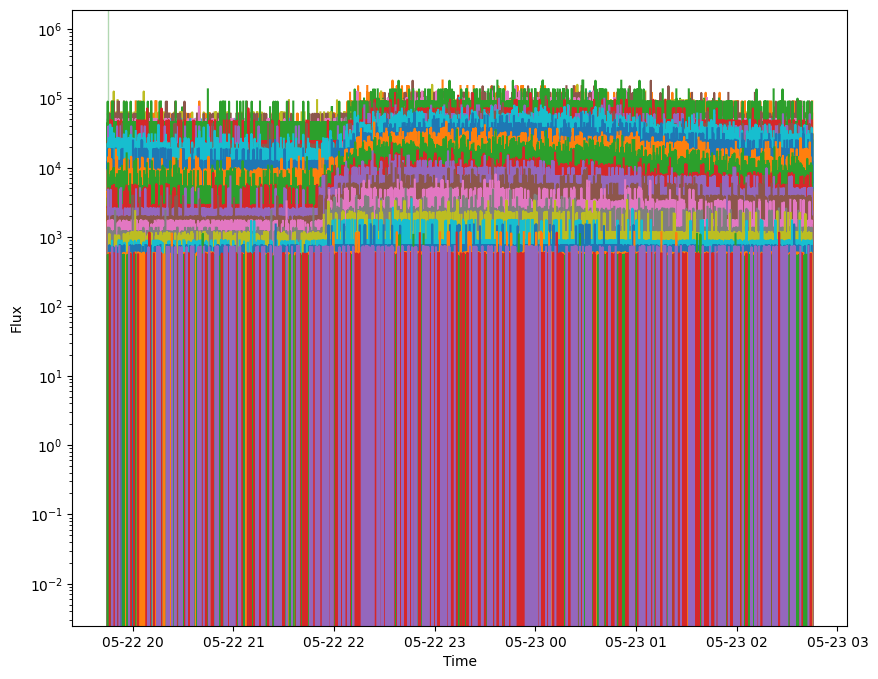

In [16]:
vda.plot_bg_selection()

In [17]:
vda.calculate_onsets()

Onset Time  \
Event No sensor particle  viewing prefix        channels                                                          
1        het    protons   sun     H_Flux        H_Flux_0-H_Flux_1                                           NaT   
                                                H_Flux_2-H_Flux_3                                           NaT   
                                                H_Flux_4-H_Flux_5                                           NaT   
                                                H_Flux_6-H_Flux_7                                           NaT   
                                                H_Flux_8-H_Flux_9                                           NaT   
...                                                                                                         ...   
         ept    electrons omni    Electron_Flux Electron_Flux_24-Electron_Flux_25 2021-05-22 21:51:49.557566080   
                                                Electron_Flux_26-Electron_Flux_27                           NaT   
                                                Electron_Flux_28-Electron_Flux_29                           NaT   
                                                Electron_Flux_30-Electron_Flux_31                           NaT   
                                                Electron_Flux_32-Electron_Flux_33                           NaT   

                                                                                               Background Start  \
Event No sensor particle  viewing prefix        channels                                                          
1        het    protons   sun     H_Flux        H_Flux_0-H_Flux_1                 2021-05-22 19:45:00.544956800   
                                                H_Flux_2-H_Flux_3                 2021-05-22 19:45:00.544956800   
                                                H_Flux_4-H_Flux_5                 2021-05-22 19:45:00.544956800   
                                                H_Flux_6-H_Flux_7                 2021-05-22 19:45:00.544956800   
                                                H_Flux_8-H_Flux_9                 2021-05-22 19:45:00.544956800   
...                                                                                                         ...   
         ept    electrons omni    Electron_Flux Electron_Flux_24-Electron_Flux_25 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_26-Electron_Flux_27 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_28-Electron_Flux_29 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_30-Electron_Flux_31 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_32-Electron_Flux_33 2021-05-22 19:45:00.544956800   

                                                                                                 Background End  \
Event No sensor particle  viewing prefix        channels                                                          
1        het    protons   sun     H_Flux        H_Flux_0-H_Flux_1                 2021-05-22 19:45:10.544973440   
                                                H_Flux_2-H_Flux_3                 2021-05-22 19:45:10.544973440   
                                                H_Flux_4-H_Flux_5                 2021-05-22 19:45:10.544973440   
                                                H_Flux_6-H_Flux_7                 2021-05-22 19:45:10.544973440   
                                                H_Flux_8-H_Flux_9                 2021-05-22 19:45:10.544973440   
...                                                                                                         ...   
         ept    electrons omni    Electron_Flux Electron_Flux_24-Electron_Flux_25 2021-05-22 19:45:10.544973440   
                                                Electron_Flux_26-Electron_

In [18]:
vda.clean_onsets()

Onset Time  \
Event No sensor particle  viewing prefix        channels                                                          
1        ept    protons   sun     H_Flux        H_Flux_12-H_Flux_13               2021-05-23 02:29:35.585184000   
                                                H_Flux_18-H_Flux_19               2021-05-23 01:51:20.581380864   
                                                H_Flux_22-H_Flux_23               2021-05-23 02:10:59.583334528   
                                                H_Flux_26-H_Flux_27               2021-05-23 02:10:46.583313024   
                                                H_Flux_42-H_Flux_43               2021-05-23 02:27:41.584995072   
...                                                                                                         ...   
                electrons omni    Electron_Flux Electron_Flux_14-Electron_Flux_15 2021-05-22 21:57:25.558122752   
                                                Electron_Flux_16-Electron_Flux_17 2021-05-22 23:01:55.564535936   
                                                Electron_Flux_20-Electron_Flux_21 2021-05-22 22:04:34.558833792   
                                                Electron_Flux_22-Electron_Flux_23 2021-05-22 22:20:44.560441088   
                                                Electron_Flux_24-Electron_Flux_25 2021-05-22 21:51:49.557566080   

                                                                                               Background Start  \
Event No sensor particle  viewing prefix        channels                                                          
1        ept    protons   sun     H_Flux        H_Flux_12-H_Flux_13               2021-05-22 19:45:00.544956800   
                                                H_Flux_18-H_Flux_19               2021-05-22 19:45:00.544956800   
                                                H_Flux_22-H_Flux_23               2021-05-22 19:45:00.544956800   
                                                H_Flux_26-H_Flux_27               2021-05-22 19:45:00.544956800   
                                                H_Flux_42-H_Flux_43               2021-05-22 19:45:00.544956800   
...                                                                                                         ...   
                electrons omni    Electron_Flux Electron_Flux_14-Electron_Flux_15 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_16-Electron_Flux_17 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_20-Electron_Flux_21 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_22-Electron_Flux_23 2021-05-22 19:45:00.544956800   
                                                Electron_Flux_24-Electron_Flux_25 2021-05-22 19:45:00.544956800   

                                                                                                 Background End  \
Event No sensor particle  viewing prefix        channels                                                          
1        ept    protons   sun     H_Flux        H_Flux_12-H_Flux_13               2021-05-22 19:45:10.544973440   
                                                H_Flux_18-H_Flux_19               2021-05-22 19:45:10.544973440   
                                                H_Flux_22-H_Flux_23               2021-05-22 19:45:10.544973440   
                                                H_Flux_26-H_Flux_27               2021-05-22 19:45:10.544973440   
                                                H_Flux_42-H_Flux_43               2021-05-22 19:45:10.544973440   
...                                                                                                         ...   
                electrons omni    Electron_Flux Electron_Flux_14-Electron_Flux_15 2021-05-22 19:45:10.544973440   
                                                Electron_Flux_16-Electron_

### <a id='toc1_2_5_'></a>[Onset Selection](#toc0_)

In [19]:
vda.construct_options_df()
# internal dataframe used for the onset selection

- Onset determination method: choose how the onset times that will be used for the VDA plots should be chosen. Options:
  - Use all: every determined onset time will be used
  - Interactive: the user is prompted to decide whether to use the determined onset (by viewing) or not individually per grouped energy channel
  - Custom list: The user should construct and provide a list defining which viewing should be used per energy channel. The list items should follow the same order as the one of the displayed plots. *(under development)*

In [20]:
vda_displayer.display_onset_selection_selection()

Dropdown(description='Onset selection method:', options=(('Use all', 0), ('Interactive', 1), ('Custom List', 2…

In [21]:
vda_displayer.select_onsets()

In [22]:
vda.parameters.selected_onsets

Viewing
Event No sensor particle  prefix        channels                                 
1        ept    protons   H_Flux        H_Flux_12-H_Flux_13                  omni
                                        H_Flux_18-H_Flux_19                  omni
                                        H_Flux_22-H_Flux_23                   sun
                                        H_Flux_26-H_Flux_27                  omni
                                        H_Flux_42-H_Flux_43                  omni
                                        H_Flux_44-H_Flux_45                  omni
                                        H_Flux_46-H_Flux_47                  omni
                                        H_Flux_2-H_Flux_3                    omni
                                        H_Flux_4-H_Flux_5                    omni
                                        H_Flux_20-H_Flux_21                  omni
                                        H_Flux_36-H_Flux_37                  omni
                electrons Electron_Flux Electron_Flux_2-Electron_Flux_3      omni
                                        Electron_Flux_4-Electron_Flux_5      omni
                                        Electron_Flux_6-Electron_Flux_7      omni
                                        Electron_Flux_8-Electron_Flux_9      omni
                                        Electron_Flux_10-Electron_Flux_11    omni
                                        Electron_Flux_12-Electron_Flux_13    omni
                                        Electron_Flux_14-Electron_Flux_15    omni
                                        Electron_Flux_16-Electron_Flux_17    omni
                                        Electron_Flux_18-Electron_Flux_19   south
                                        Electron_Flux_20-Electron_Flux_21    omni
                                        Electron_Flux_24-Electron_Flux_25    omni
                                        Electron_Flux_22-Electron_Flux_23    omni

## <a id='toc1_3_'></a>[VDA](#toc0_)

### <a id='toc1_3_5_1_'></a>[Channels](#toc0_)

In [23]:
vda.construct_energy_channels_characteristics()

Geomagnetic Mean  \
sensor particle  channel                                               
het    protons   H_Flux_0-H_Flux_1                          7.455538   
                 H_Flux_2-H_Flux_3                          8.512447   
                 H_Flux_4-H_Flux_5                          9.931574   
                 H_Flux_6-H_Flux_7                         11.040788   
                 H_Flux_8-H_Flux_9                         11.877732   
...                                                              ...   
ept    electrons Electron_Flux_24-Electron_Flux_25          0.218338   
                 Electron_Flux_26-Electron_Flux_27          0.259333   
                 Electron_Flux_28-Electron_Flux_29          0.308012   
                 Electron_Flux_30-Electron_Flux_31          0.366071   
                 Electron_Flux_32-Electron_Flux_33          0.435110   

                                                    Inverse Beta  
sensor particle  channel                                          
het    protons   H_Flux_0-H_Flux_1                      7.979684  
                 H_Flux_2-H_Flux_3                      7.474141  
                 H_Flux_4-H_Flux_5                      6.927340  
                 H_Flux_6-H_Flux_7                      6.575906  
                 H_Flux_8-H_Flux_9                      6.344178  
...                                                          ...  
ept    electrons Electron_Flux_24-Electron_Flux_25      1.401504  
                 Electron_Flux_26-Electron_Flux_27      1.336345  
                 Electron_Flux_28-Electron_Flux_29      1.279613  
                 Electron_Flux_30-Electron_Flux_31      1.230400  
                 Electron_Flux_32-Electron_Flux_33      1.188218  

[69 rows x 2 columns]

### <a id='toc1_3_5_2_'></a>[Spacecraft](#toc0_)

In [24]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fe3505c8a00>

In [25]:
vda.define_spacecraft_parameters()

/home/liadlow/Development/Work/NOA/Projects/SPEARHEAD/tools/VDA/venv_vda_tool/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['2020-02-10 04:55:49.670' '2030-11-20 04:06:35.152']


/home/liadlow/Development/Work/NOA/Projects/SPEARHEAD/tools/VDA/venv_vda_tool/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/liadlow/Development/Work/NOA/Projects/SPEARHEAD/tools/VDA/venv_vda_tool/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


### <a id='toc1_3_5_3_'></a>[Plots](#toc0_)

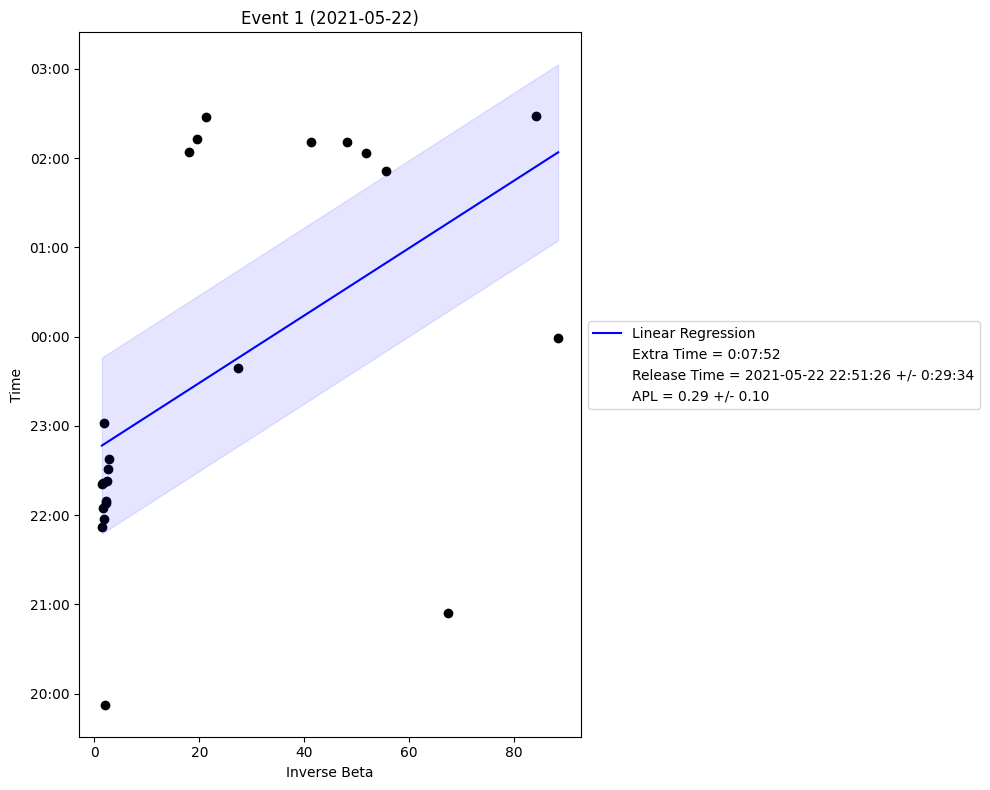

In [26]:
vda.plot()